# Per-Class Accuracy Analysis

**Purpose**: Analyze model performance on test set
- Download checkpoint from Google Drive
- Evaluate per-class accuracy
- Visualize class distribution and performance

In [15]:
!uv pip install -q transformers gdown

In [16]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## 1. Configuration

In [17]:
# Model Config
MODEL_CKPT = 'MCG-NJU/videomae-base-finetuned-kinetics'
NUM_FRAMES = 16
IMG_SIZE = 224
RESIZE_SIZE = 256
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Paths
PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'

# Google Drive file ID for best_p1.pt https://drive.google.com/file/d/190-LrBgEJOyWJQtP0tpvLz0P3TmmxKw7/view?usp=drive_link
CHECKPOINT_FILE_ID = '190-LrBgEJOyWJQtP0tpvLz0P3TmmxKw7'

## 2. Download Checkpoint

In [18]:
# Download best_p1.pt from Google Drive
!gdown {CHECKPOINT_FILE_ID} -O best_p1.pt

# Download test labels
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q

print('✓ Checkpoint and labels downloaded')

Downloading...
From (original): https://drive.google.com/uc?id=190-LrBgEJOyWJQtP0tpvLz0P3TmmxKw7
From (redirected): https://drive.google.com/uc?id=190-LrBgEJOyWJQtP0tpvLz0P3TmmxKw7&confirm=t&uuid=6c6c4ce3-2558-41cc-9cae-6f72b8b18ab8
To: /kaggle/working/best_p1.pt
100%|█████████████████████████████████████████| 345M/345M [00:01<00:00, 203MB/s]
✓ Checkpoint and labels downloaded


## 3. Dataset Classes

In [19]:
class VideoDataset(Dataset):
    def __init__(self, root, num_frames=16):
        self.root = Path(root)
        self.num_frames = num_frames
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            cls_dir = self.root / cls
            for video_dir in sorted([d for d in cls_dir.iterdir() if d.is_dir()]):
                self.samples.append((video_dir, self.class_to_idx[cls]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_dir, label = self.samples[idx]
        frame_paths = sorted(video_dir.glob('*.jpg'))
        indices = np.linspace(0, len(frame_paths) - 1, self.num_frames, dtype=int)
        frames = [TF.resize(Image.open(frame_paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        return torch.stack(processed), label

class TestDataset(Dataset):
    def __init__(self, root, num_frames=16):
        self.root = Path(root)
        self.num_frames = num_frames
        self.samples = sorted([(d, int(d.name)) for d in self.root.iterdir() if d.is_dir()], key=lambda x: x[1])
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        video_dir, video_id = self.samples[idx]
        frame_paths = sorted(video_dir.glob('*.jpg'))
        indices = np.linspace(0, len(frame_paths) - 1, self.num_frames, dtype=int)
        frames = [TF.resize(Image.open(frame_paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        return torch.stack(processed), video_id

print('Dataset classes defined')

Dataset classes defined


## 4. Load Data & Model

In [20]:
# Load datasets
train_dataset = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES)
test_dataset = TestDataset(PATH_DATA_TEST, NUM_FRAMES)

# Ground truth
gt_df = pd.read_csv('test_labels.csv')
gt_dict = dict(zip(gt_df['id'].astype(str), gt_df['class']))

# DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f'Train samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Classes: {len(train_dataset.classes)}')

Train samples: 6254
Test samples: 510
Classes: 51


In [21]:
# Load model
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(train_dataset.classes),
    ignore_mismatched_sizes=True,
    num_frames=NUM_FRAMES
).to(DEVICE)

# Load checkpoint
model.load_state_dict(torch.load('best_p1.pt', map_location=DEVICE))
model.eval()

print('✓ Model loaded with checkpoint')

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([51]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([51, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded with checkpoint


## 5. Evaluate on Test Set

In [22]:
# Get predictions
all_preds = []
all_true = []

with torch.no_grad():
    for videos, video_ids in tqdm(test_loader, desc='Evaluating'):
        videos = videos.to(DEVICE)
        preds = model(videos).logits.argmax(1).cpu().tolist()
        
        for vid, pred in zip(video_ids.tolist(), preds):
            true_label = gt_dict[str(vid)]
            all_true.append(true_label)
            all_preds.append(train_dataset.classes[pred])

# Overall accuracy
from sklearn.metrics import accuracy_score
overall_acc = accuracy_score(all_true, all_preds)

print(f'\n' + '=' * 60)
print(f'OVERALL TEST ACCURACY: {overall_acc:.4f} ({overall_acc*100:.2f}%)')
print('=' * 60)

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


OVERALL TEST ACCURACY: 0.8451 (84.51%)


## 6. Per-Class Classification Report

In [23]:
# Classification report
report = classification_report(all_true, all_preds, target_names=train_dataset.classes, 
                                digits=4, zero_division=0)
print(report)

# Save report
with open('per_class_report.txt', 'w') as f:
    f.write(f'Overall Accuracy: {overall_acc:.4f}\n\n')
    f.write(report)

print('\n✓ Saved to per_class_report.txt')

                precision    recall  f1-score   support

    brush_hair     1.0000    0.9000    0.9474        10
     cartwheel     0.9000    0.9000    0.9000        10
         catch     1.0000    0.7000    0.8235        10
          chew     1.0000    1.0000    1.0000        10
          clap     1.0000    1.0000    1.0000        10
         climb     1.0000    0.9000    0.9474        10
  climb_stairs     0.8000    0.4000    0.5333        10
          dive     1.0000    0.8000    0.8889        10
    draw_sword     1.0000    1.0000    1.0000        10
       dribble     1.0000    0.9000    0.9474        10
         drink     0.9091    1.0000    0.9524        10
           eat     0.8333    1.0000    0.9091        10
    fall_floor     0.6667    0.8000    0.7273        10
       fencing     0.7500    0.9000    0.8182        10
     flic_flac     0.9000    0.9000    0.9000        10
          golf     1.0000    1.0000    1.0000        10
     handstand     1.0000    1.0000    1.0000  

## 7. Training Set Class Distribution

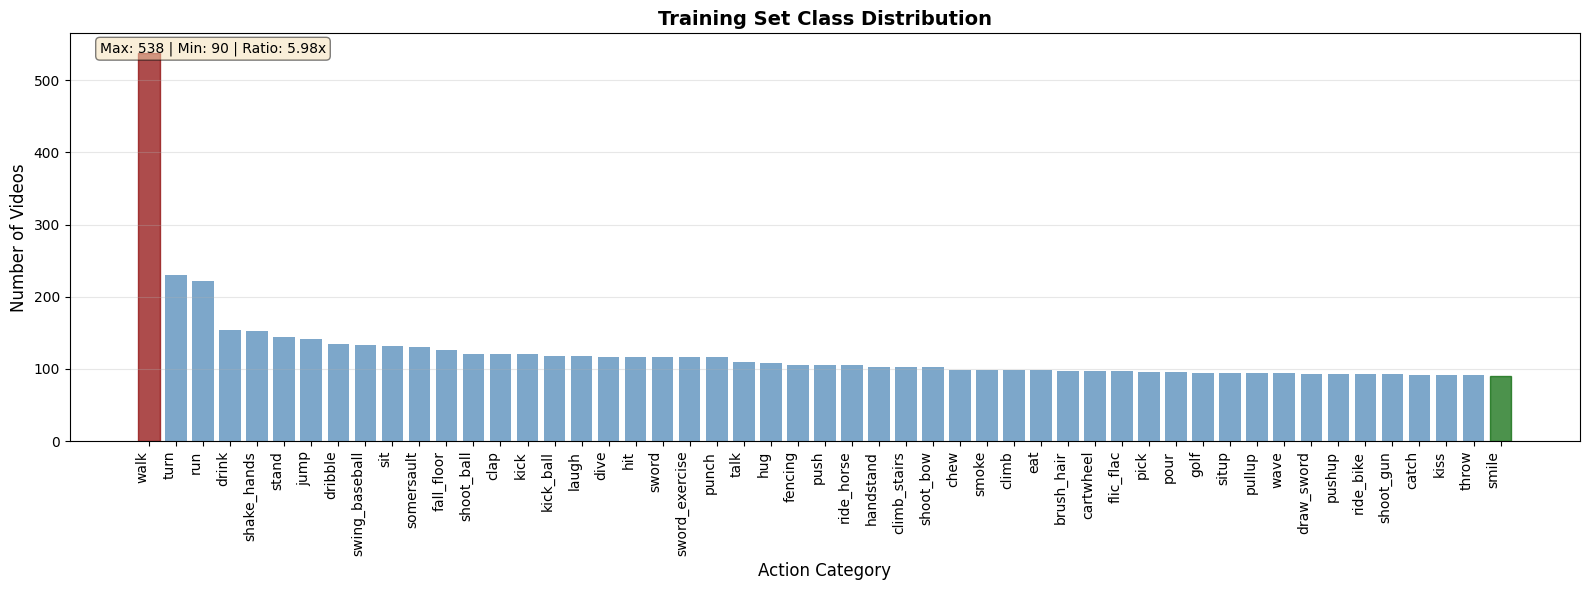

Imbalance ratio: 5.98x


In [24]:
# Count samples per class in train set
class_counts = Counter([label for _, label in train_dataset.samples])
class_names = train_dataset.classes

# Sort by count
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
sorted_names = [class_names[idx] for idx, _ in sorted_classes]
sorted_counts = [count for _, count in sorted_classes]

# Plot
plt.figure(figsize=(16, 6))
bars = plt.bar(range(len(sorted_names)), sorted_counts, color='steelblue', alpha=0.7)
plt.xlabel('Action Category', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(len(sorted_names)), sorted_names, rotation=90, ha='right')
plt.grid(axis='y', alpha=0.3)

# Highlight extremes
bars[0].set_color('darkred')
bars[-1].set_color('darkgreen')

# Stats
max_count = sorted_counts[0]
min_count = sorted_counts[-1]
ratio = max_count / min_count
plt.text(0.02, 0.98, f'Max: {max_count} | Min: {min_count} | Ratio: {ratio:.2f}x', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('train_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Imbalance ratio: {ratio:.2f}x')

## 8. Per-Class Test Accuracy

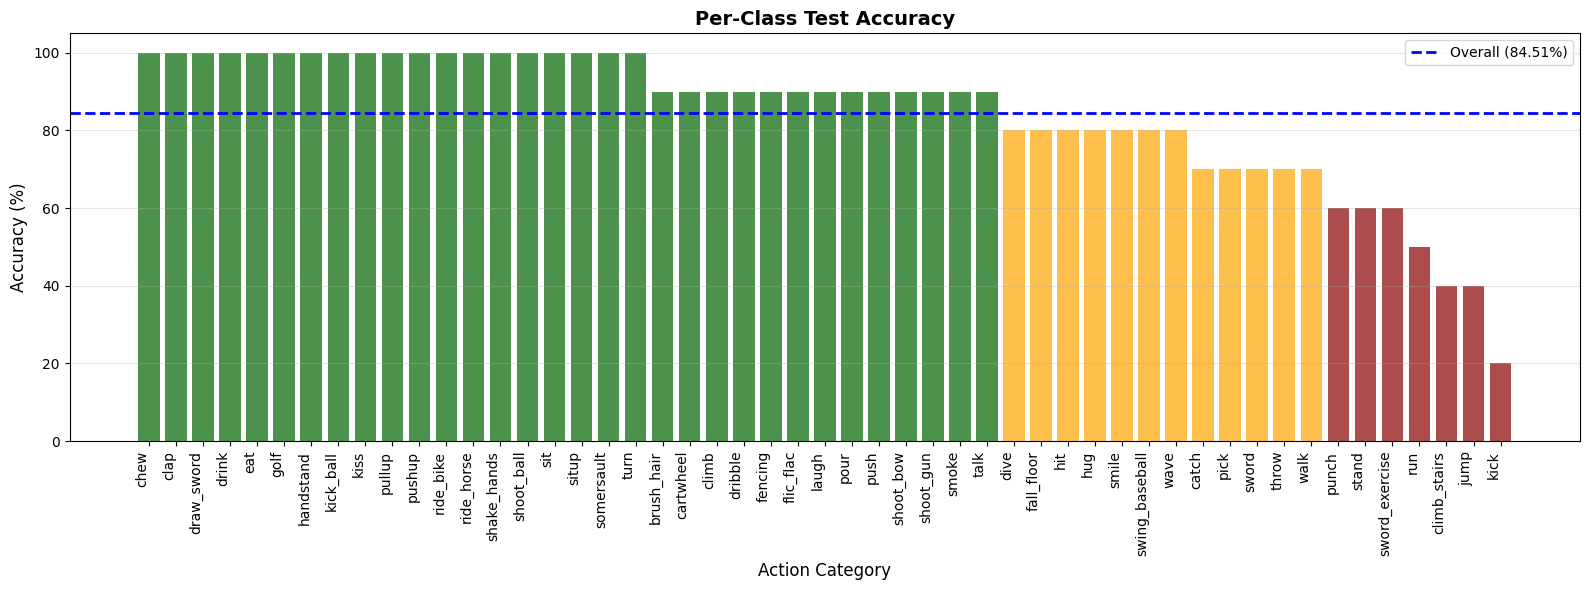

In [25]:
# Extract per-class metrics
report_dict = classification_report(all_true, all_preds, target_names=train_dataset.classes, 
                                     output_dict=True, zero_division=0)

# Extract recall (accuracy) per class
class_accs = [(cls, report_dict[cls]['recall']) for cls in train_dataset.classes]
class_accs_sorted = sorted(class_accs, key=lambda x: x[1], reverse=True)

cls_names = [c[0] for c in class_accs_sorted]
cls_accs_vals = [c[1] * 100 for c in class_accs_sorted]

# Plot
plt.figure(figsize=(16, 6))
colors = ['darkgreen' if acc >= 90 else 'orange' if acc >= 70 else 'darkred' for acc in cls_accs_vals]
bars = plt.bar(range(len(cls_names)), cls_accs_vals, color=colors, alpha=0.7)
plt.axhline(y=overall_acc*100, color='blue', linestyle='--', linewidth=2, label=f'Overall ({overall_acc*100:.2f}%)')
plt.xlabel('Action Category', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Test Accuracy', fontsize=14, fontweight='bold')
plt.xticks(range(len(cls_names)), cls_names, rotation=90, ha='right')
plt.ylim(0, 105)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
print('\n' + '=' * 60)
print('🏆 Top-5 Best Performing Classes:')
print('=' * 60)
for i in range(min(5, len(cls_names))):
    print(f'{i+1:2d}. {cls_names[i]:20s} {cls_accs_vals[i]:6.2f}%')

print('\n' + '=' * 60)
print('⚠️  Top-5 Worst Performing Classes:')
print('=' * 60)
for i in range(max(0, len(cls_names)-5), len(cls_names)):
    print(f'{len(cls_names)-i:2d}. {cls_names[i]:20s} {cls_accs_vals[i]:6.2f}%')


🏆 Top-5 Best Performing Classes:
 1. chew                 100.00%
 2. clap                 100.00%
 3. draw_sword           100.00%
 4. drink                100.00%
 5. eat                  100.00%

⚠️  Top-5 Worst Performing Classes:
 5. sword_exercise        60.00%
 4. run                   50.00%
 3. climb_stairs          40.00%
 2. jump                  40.00%
 1. kick                  20.00%


## 9. Top Confusion Pairs

In [27]:
# Confusion matrix
cm = confusion_matrix(all_true, all_preds, labels=train_dataset.classes)

# Find top confusions (off-diagonal)
confusions = []
for i in range(len(train_dataset.classes)):
    for j in range(len(train_dataset.classes)):
        if i != j and cm[i, j] > 0:
            confusions.append((train_dataset.classes[i], train_dataset.classes[j], cm[i, j]))

# Sort by confusion count
confusions.sort(key=lambda x: x[2], reverse=True)

print('\n' + '=' * 70)
print('Top-10 Confusion Pairs (True → Predicted)')
print('=' * 70)
for i, (true_cls, pred_cls, count) in enumerate(confusions[:10]):
    print(f'{i+1:2d}. {true_cls:20s} → {pred_cls:20s} ({int(count):2d} errors)')


Top-10 Confusion Pairs (True → Predicted)
 1. jump                 → run                  ( 4 errors)
 2. climb_stairs         → run                  ( 3 errors)
 3. sword                → fencing              ( 3 errors)
 4. hug                  → shake_hands          ( 2 errors)
 5. kick                 → fall_floor           ( 2 errors)
 6. smile                → talk                 ( 2 errors)
 7. wave                 → talk                 ( 2 errors)
 8. brush_hair           → laugh                ( 1 errors)
 9. cartwheel            → flic_flac            ( 1 errors)
10. catch                → punch                ( 1 errors)


In [28]:
# Save summary stats
summary = {
    'overall_accuracy': overall_acc,
    'best_class': cls_names[0],
    'best_acc': cls_accs_vals[0] / 100,
    'worst_class': cls_names[-1],
    'worst_acc': cls_accs_vals[-1] / 100,
    'imbalance_ratio': ratio
}

pd.DataFrame([summary]).to_csv('analysis_summary.csv', index=False)
print('\n✓ Saved analysis_summary.csv')


✓ Saved analysis_summary.csv
